In [23]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Epoch 1/10, Training Loss: 0.2408, Training Accuracy: 93.26%
Testing Loss: 0.0937, Testing Accuracy: 97.02%
Epoch 2/10, Training Loss: 0.0818, Training Accuracy: 97.54%
Testing Loss: 0.0745, Testing Accuracy: 97.67%
Epoch 3/10, Training Loss: 0.0587, Training Accuracy: 98.20%
Testing Loss: 0.0782, Testing Accuracy: 97.47%
Epoch 4/10, Training Loss: 0.0463, Training Accuracy: 98.58%
Testing Loss: 0.0680, Testing Accuracy: 97.82%
Epoch 5/10, Training Loss: 0.0391, Training Accuracy: 98.76%
Testing Loss: 0.0571, Testing Accuracy: 98.23%
Epoch 6/10, Training Loss: 0.0326, Training Accuracy: 98.97%
Testing Loss: 0.0692, Testing Accuracy: 97.89%
Epoch 7/10, Training Loss: 0.0260, Training Accuracy: 99.19%
Testing Loss: 0.0642, Testing Accuracy: 98.09%
Epoch 8/10, Training Loss: 0.0227, Training Accuracy: 99.26%
Testing Loss: 0.0562, Testing Accuracy: 98.31%
Epoch 9/10, Training Loss: 0.0182, Training Accuracy: 99.44%
Testing Loss: 0.0564, Testing Accuracy: 98.27%
Epoch 10/10, Training Loss: 

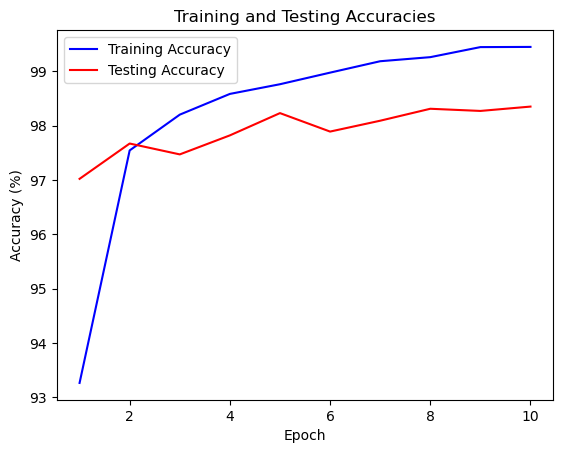

Final Training Accuracy: 99.45%
Final Testing Accuracy: 98.35%


In [11]:
# Define a custom dataset class for MNIST
class MNISTDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the MNIST training set
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load the MNIST test set
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model & define hyperparameters
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 30
num_epochs = 10

train_accuracies = []
test_accuracies = []
writer = SummaryWriter()

for epoch in range(num_epochs):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # Training Loop
    for images, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_dataset)
    train_accuracy = 100.0 * train_correct / train_total

    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
    # Write training metrics to Tensorboard
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)

    # Testing loop
    test_loss = 0.0
    test_total = 0
    test_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            test_loss += loss.item() * images.size(0)

    test_loss /= len(test_dataset)
    test_accuracy = 100.0 * test_correct / test_total

    test_accuracies.append(test_accuracy)
    print(f'Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.2f}%')

    # Write testing metrics to Tensorboard
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch)

    # Select a few images from the test dataset
    sample_images, _ = next(iter(test_loader))
    # Write the images to Tensorboard
    writer.add_images('Images', sample_images, global_step=epoch)

# Close the SummaryWriter
writer.close()

# Plot the training and testing accuracies over epochs
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r', label='Testing Accuracy')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Print overall training and testing accuracies
print(f'Final Training Accuracy: {train_accuracies[-1]:.2f}%')
print(f'Final Testing Accuracy: {test_accuracies[-1]:.2f}%')

In [20]:
%load_ext tensorboard
%tensorboard --logdir=runs

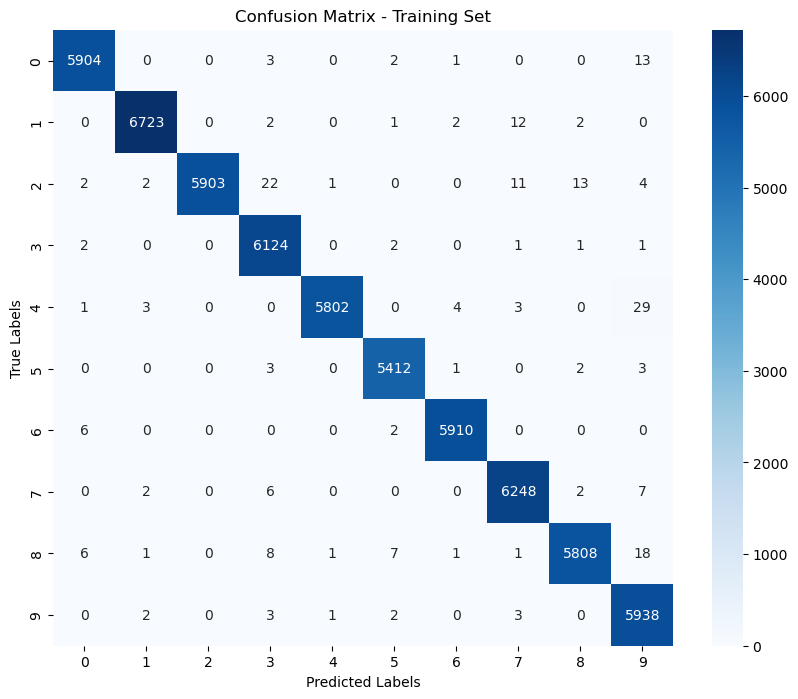

In [24]:
# Generate the confusion matrix for the training set
model.eval()
train_predictions = []
train_true_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.tolist())
        train_true_labels.extend(labels.tolist())

train_cm = confusion_matrix(train_true_labels, train_predictions)

class_names = [str(i) for i in range(10)]
plt.figure(figsize=(10, 8))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [26]:
# DEPLOYMENT
import tarfile
import sagemaker
import boto3
from sagemaker.pytorch import PyTorchModel

torch.save(model.state_dict(), "MNIST.pt")
model_file_key = 'MNIST.pt'
archive_path = 'MNIST.tar.gz'

# Create a tar.gz archive
with tarfile.open(archive_path, 'w:gz') as tar:
    tar.add(model_file_key, arcname='MNIST.pth')

print('tar.gz archive created successfully.')

# Upload the model tar.gz archive to S3
s3_bucket = 'sid-test-bucket'
s3_model_key = 'MNIST.tar.gz'
s3_model_path = f's3://{s3_bucket}/{s3_model_key}'

s3_client = boto3.client('s3')
s3_client.upload_file(archive_path, s3_bucket, s3_model_key)

# Create an endpoint using SageMaker Python SDK
role = sagemaker.get_execution_role()
sess = sagemaker.Session()

# Create a PyTorchModel
pytorch_model = PyTorchModel(model_data=s3_model_path,
                             role=role,
                             framework_version='1.8.1',
                             py_version='py3',
                             sagemaker_session=sess)

# Deploy the model to an endpoint
endpoint_name = 'MNIST-endpoint-sid'
predictor = pytorch_model.deploy(endpoint_name=endpoint_name,
                                 initial_instance_count=1,
                                 instance_type='ml.m5.large')

# Wait for the deployment to complete
sess.wait_for_endpoint(endpoint_name)

print("tar.gz archive created successfully.")
print("------------------------------------!")

tar.gz archive created successfully.
------------------------------------!
